## Data Understanding

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import re


<h4 style="color:#3f79ffff; margin:0; font-weight:600;">First I check the shape of the data and how our data set looks like and what anomalies there are and how we can clean the data so we can use it as efficient as possible later on in the process.

In [ ]:
# load data
df = pd.read_excel("../data/phone_transcripts_v0.1.xlsx")

# inspect data
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CallID      100 non-null    int64 
 1   Date        100 non-null    object
 2   Duration    100 non-null    object
 3   Transcript  100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


,CallID,Date,Duration,Transcript
0,1,15/01/2025,06:32:00,"Caller: Hi there, I recently purchased a blend..."
1,2,20/02/2025,07:45:00,"Caller: Hello, I was wondering if your webshop..."
2,3,10/03/2025,05:18:00,"Caller: The pair of shoes I ordered arrived, b..."
3,4,05/04/2025,08:10:00,"Caller: Hi, I'm shopping for wireless earbuds ..."
4,5,22/05/2025,04:25:00,Caller: I see a pending charge on my credit ca...


In [ ]:
# show more transcript texts
with pd.option_context('display.max_colwidth', 160):
    display(df['Transcript'].head(10))

0    Caller: Hi there, I recently purchased a blender from your site, but it's making this awful grinding noise after just a couple of uses. I'm really disappoin...
1    Caller: Hello, I was wondering if your webshop ships products to Canada, and if so, what are the shipping fees and estimated delivery times? I'm interested ...
2    Caller: The pair of shoes I ordered arrived, but they're a size too small and pinching my toes. Can I exchange them for the next size up? Agent: Of course, ...
3    Caller: Hi, I'm shopping for wireless earbuds and need some recommendations for ones under $50 that have decent sound quality for everyday use like commutin...
4    Caller: I see a pending charge on my credit card from your store, but I haven't received any order confirmation email yet. Is everything okay? Agent: Let me...
5    Caller: Hello, I'd like to have my order gift-wrapped with a personal note inside. Is that something you can do, and how much extra does it cost? Agent: Yes...
6    Calle

In [ ]:
# clean data by converting Date to datetime and Duration to seconds
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["Duration"] = pd.to_timedelta(df["Duration"])
df["Duration"] = df["Duration"].dt.total_seconds()
df["Duration"] = df["Duration"].astype(int)
df.head(5)


,CallID,Date,Duration,Transcript
0,1,2025-01-15,23520,"Caller: Hi there, I recently purchased a blend..."
1,2,2025-02-20,27900,"Caller: Hello, I was wondering if your webshop..."
2,3,2025-03-10,19080,"Caller: The pair of shoes I ordered arrived, b..."
3,4,2025-04-05,29400,"Caller: Hi, I'm shopping for wireless earbuds ..."
4,5,2025-05-22,15900,Caller: I see a pending charge on my credit ca...


In [ ]:
# approximate word count per transcript
df['Transcript'].str.split().str.len().head(10)

0    164
1    138
2    112
3    130
4     86
5    116
6    112
7     77
8     64
9     82
Name: Transcript, dtype: int64

<h4 style="color:#3f79ffff; margin:0; font-weight:600;">Plot word count distribution of transcripts lengths (important for chunking)</h4>


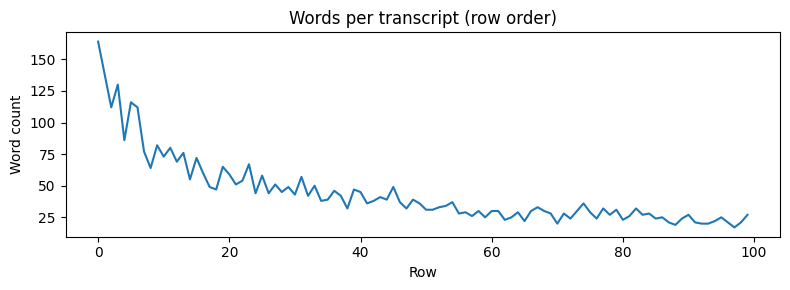

Mean: 44.12 Median: 35.0 Min: 17 Max: 164


In [ ]:
wc = df['Transcript'].fillna('').str.split().str.len()
ax = wc.reset_index(drop=True).plot(kind='line', figsize=(8,3), title='Words per transcript (row order)')
ax.set_xlabel('Row')
ax.set_ylabel('Word count')
plt.tight_layout()
plt.show()
print("Mean:", wc.mean(), "Median:", wc.median(), "Min:", wc.min(), "Max:", wc.max())

## Chunk Data

<h4 style="color:#3f79ffff; margin:0; font-weight:600;">Going through all rows in the dataframe and splitting text from "Caller" and "Agent", then appending everything to a new dataframe with a "chunk_id" which we will later use as the ID of the data chunks.

In [ ]:
def chunk_per_speaker_simple(df):
    all_chunks = []

    for _, row in df.iterrows():
        call_id = row["CallID"]
        date = row["Date"]
        duration = row["Duration"]
        transcript = row["Transcript"]

        # Split the text on Caller:/Agent:
        parts = re.split(r"(Caller:|Agent:)", transcript)

        chunk_id = 1
        for i in range(1, len(parts), 2):
            speaker = parts[i].replace(":", "").strip()  # 'Caller' or 'Agent'
            text = parts[i+1].strip()                    # what they said
            
            if text:  # only add non-empty texts
                all_chunks.append({
                    "call_id": call_id,
                    "chunk_id": f"{call_id}_{chunk_id}",
                    "date": date,
                    "duration": duration,
                    "speaker": speaker,
                    "transcript": f"{speaker}: {text}"  
                })
                chunk_id += 1

    return pd.DataFrame(all_chunks)

chunks_df = chunk_per_speaker_simple(df)

<h4 style="color:#3f79ffff; margin:0; font-weight:600;">Some final checks to see if everything is right and then saving it to a csv so we can later use it to embed and persist.<h4>

In [52]:
chunks_df.head(15)

,call_id,chunk_id,date,duration,speaker,transcript
0,1,1_1,2025-01-15,23520,Caller,"Caller: Hi there, I recently purchased a blend..."
1,1,1_2,2025-01-15,23520,Agent,Agent: I'm so sorry to hear about that issue w...
2,1,1_3,2025-01-15,23520,Caller,"Caller: Sure, the order number is 45678. Do yo..."
3,1,1_4,2025-01-15,23520,Agent,"Agent: Absolutely, this sounds like a manufact..."
4,1,1_5,2025-01-15,23520,Caller,"Caller: I'd love a replacement, please. Yes, I..."
5,1,1_6,2025-01-15,23520,Agent,Agent: No problem at all. I'll process that re...
6,2,2_1,2025-02-20,27900,Caller,"Caller: Hello, I was wondering if your webshop..."
7,2,2_2,2025-02-20,27900,Agent,"Agent: Yes, we do offer international shipping..."
8,2,2_3,2025-02-20,27900,Caller,Caller: That sounds reasonable. Is there any w...
9,2,2_4,2025-02-20,27900,Agent,"Agent: Definitely, you'll get a tracking numbe..."


In [60]:
with pd.option_context('display.max_colwidth', None):
    display(chunks_df['transcript'].sample(10))

95                                                              Agent: As a one-time courtesy, yes. What's the code?
78                            Caller: I can't seem to find my wish list on the site anymore. It was there yesterday.
416                                                                  Caller: Hi, is your coffee sustainably sourced?
36                      Caller: Order number 11223. I'd prefer a full refund rather than a replacement, if possible.
187                                                                                  Agent: Shop with peace of mind.
124                                                                          Caller: Signed up! Thanks for the info.
466                                                       Caller: Hello, can you extend the flash sale? I missed it.
73     Agent: Our clothing is made from recycled fabrics and organic cotton, with certifications for sustainability.
376                                                             

In [54]:
print("Total chunks:", len(chunks_df))


Total chunks: 516


In [ ]:
# save to csv
chunks_df.to_csv("phone_transcripts_v0.1_chunks.csv", index=False)
print("Saved to phone_transcripts_v0.1_chunks.csv")

Saved to phone_transcripts_v0.1_chunks.csv
